<a href="https://colab.research.google.com/github/SERVIR/GEDI_Earthhub_ARSET_Training/blob/main/Module_II_Exploring_Forest_Structure_with_GEDI_L2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Module II: Exploring Forest Structure with GEDI L2B

run the pip install to to load the needed packages

re-run the cell if/when the restart prompt is given

In [1]:
!pip install earthaccess harmony-py hvplot folium geopandas geoviews

Make a new folder to work in and change directory to that location

In [2]:
!mkdir Module_2_GEDI_L2b

!mkdir Module_2_GEDI_L2b/SPB_AOI
!mkdir Module_2_GEDI_L2b/Prescribed_Burn_AOI
!mkdir Module_2_GEDI_L2b/Sewanee_Domain
!mkdir Module_2_GEDI_L2b/PaintRock_AOI

mkdir: cannot create directory ‘Module_2_GEDI_L2b’: File exists
mkdir: cannot create directory ‘Module_2_GEDI_L2b/SPB_AOI’: File exists
mkdir: cannot create directory ‘Module_2_GEDI_L2b/Prescribed_Burn_AOI’: File exists
mkdir: cannot create directory ‘Module_2_GEDI_L2b/Sewanee_Domain’: File exists
mkdir: cannot create directory ‘Module_2_GEDI_L2b/PaintRock_AOI’: File exists


Change directory to that new folder

In [3]:
%cd /content/Module_2_GEDI_L2b

/content/Module_2_GEDI_L2b


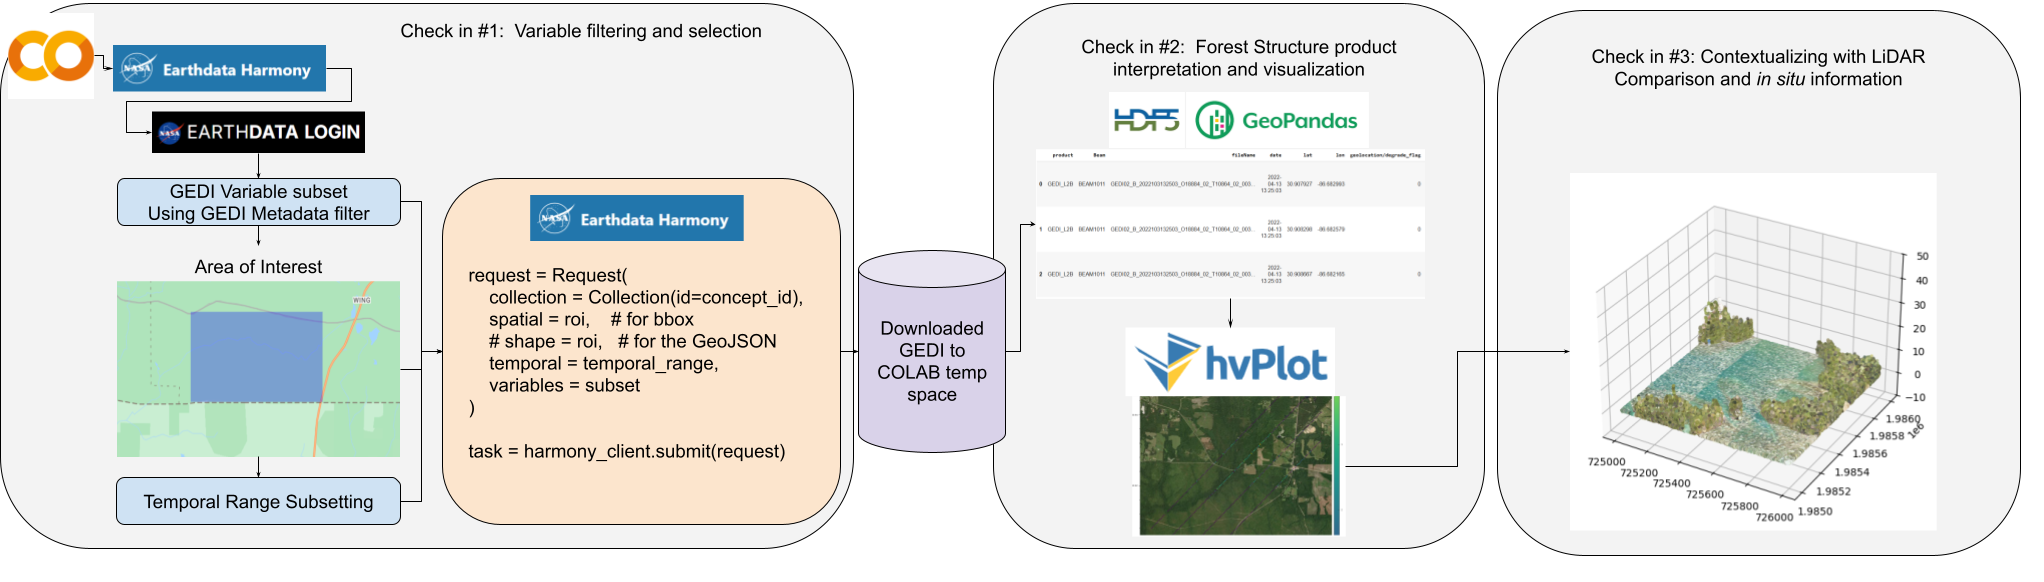

Link to editable workflow (to be removed at the end) https://docs.google.com/drawings/d/1q49Oa-y9W5X25_Qijg0IuSczzcVrcOX5mVfiyIO_UmE/edit

Load the needed packages

In [4]:
from harmony import BBox, Client, Collection, Request, CapabilitiesRequest
from datetime import datetime
import json
import earthaccess
import geopandas as gp
import os
from IPython.display import JSON
import h5py
import pandas as pd
from shapely.geometry import Point
import hvplot.pandas
import folium
from folium import GeoJson
from IPython.display import display, HTML
import requests
from io import StringIO

from datetime import datetime

# gv.extension('bokeh', 'matplotlib')
from holoviews import opts
import shapely
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

os.chdir('../../')

## Authenticate

Pause here and set up your arorund and have your username and password ready for this next section. See the [EarthData Login](https://urs.earthdata.nasa.gov/) if you dont have an account yet.

`earthaccess.login()` is used here to access NASA Earthdata Login (EDL) credentials stored in a .netrc file and allows users to type their credentials and persist them to a .netrc file if one does not exist.

In [5]:
auth = earthaccess.login(persist=True)
# auth.token

Enter your Earthdata Login username: tjm0042
Enter your Earthdata password: ··········


To access data through Harmony service, we need to create a Harmony Client object using either your EDL token or your Earthdata Login credentials. Below, `username` and `password` are directly provided to `Client` function. See [here](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for other options you can create Harmony Client object.

In [6]:
harmony_client = Client(auth=(auth.username, auth.password))

# Visualize our Areas of intres (AOI)

Add relivant phyphysical and forest informaiton regarind these sites see  the folder here with the docs to support this: https://drive.google.com/drive/folders/1WvBSUIHy6I05j8s1ZZRarho5qnG2wdnb

In [7]:
# Bring in aois
geojson_urls = {
    "SPB_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/SPB_AOI.geojson",
    "Prescribed_Burn_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/prescribed_burn_aoi.geojson",
    "Sewanee_Domain": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/Sewanee_Domain.geojson",
    "PaintRockAOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/PaintRockAOI.geojson"
}

In [8]:
# Load GeoJSONs into GeoDataFrames and store map HTML
geojson_gdfs = {}
maps_html = []

def create_map_and_gdf(name, url):
    # Get GeoJSON from URL
    geojson_data = requests.get(url).json()

    # Create GeoDataFrame
    gdf = gp.GeoDataFrame.from_features(geojson_data["features"])
    geojson_gdfs[name] = gdf

    # Determine map center
    coords = geojson_data['features'][0]['geometry']['coordinates']
    geom_type = geojson_data['features'][0]['geometry']['type']

    if geom_type == "Polygon":
        coords = coords[0]
    elif geom_type == "MultiPolygon":
        coords = coords[0][0]
    else:
        raise ValueError(f"Unsupported geometry type: {geom_type}")

    lat = sum(pt[1] for pt in coords) / len(coords)
    lon = sum(pt[0] for pt in coords) / len(coords)

    # Create map
    fmap = folium.Map(location=[lat, lon], zoom_start=13, tiles="OpenStreetMap")
    folium.GeoJson(geojson_data, name=name).add_to(fmap)

    # Return rendered HTML
    return fmap._repr_html_()

# Generate maps and GeoDataFrames
for name, url in geojson_urls.items():
    html_map = create_map_and_gdf(name, url)
    maps_html.append(html_map)


In [9]:
# Display maps side by side
html = f"""
<div style="display: flex; flex-wrap: wrap;">
    {''.join([f'<div style="flex: 1; min-width: 400px; margin: 5px;">{m}</div>' for m in maps_html])}
</div>
"""
display(HTML(html))

In [10]:
##Pull out the geopanda dataframes
SPB_AOI = geojson_gdfs["SPB_AOI"]
Prescribed_Burn_AOI = geojson_gdfs["Prescribed_Burn_AOI"]
Sewanee_Domain = geojson_gdfs["Sewanee_Domain"]
PaintRock_AOI = geojson_gdfs["PaintRockAOI"]

In [11]:
## Create a convex hull (total bounds) polyogn of your AOI so Harmony client can download the bounds
minx, miny, maxx, maxy = SPB_AOI.total_bounds
SPB_AOI_roi = (minx, miny, maxx, maxy)

minx, miny, maxx, maxy = Prescribed_Burn_AOI.total_bounds
Prescribed_Burn_AOI_roi = (minx, miny, maxx, maxy)

minx, miny, maxx, maxy = Sewanee_Domain.total_bounds
Sewanee_Domain_roi = (minx, miny, maxx, maxy)

minx, miny, maxx, maxy = PaintRock_AOI.total_bounds
PaintRock_AOI_roi = (minx, miny, maxx, maxy)

In [12]:
# # Store all bbox objects in a dictionary for later use
# bbox_dict = {}

# for name, url in geojson_urls.items():
#     gdf = gp.read_file(url)
#     minx, miny, maxx, maxy = gdf.total_bounds
#     bbox = BBox(minx, miny, maxx, maxy)
#     bbox_dict[f"{name}_roi"] = bbox


# # Print all bounding boxes in the desired format
# for var_name, bbox in bbox_dict.items():
#     print(f"{var_name} = BBox({bbox.minx}, {bbox.miny}, {bbox.maxx}, {bbox.maxy})")



# # SPB_AOI_roi = bbox_dict["SPB_AOI_roi"]
# # print(SPB_AOI_roi)
# # Prescribed_Burn_AOI_roi = bbox_dict["Prescribed_Burn_AOI_roi"]
# # print(Prescribed_Burn_AOI_roi)
# # Sewanee_Domain_roi = bbox_dict["Sewanee_Domain_roi"]
# # print(Sewanee_Domain_roi)
# # PaintRockAOI_roi = bbox_dict["PaintRockAOI_roi"]
# # print(PaintRockAOI_roi)
# # Prescribed_Burn_AOI_roi = BBox(-86.68320982, 30.99529573, -86.62706739, 31.02423368)
# # Sewanee_Domain_roi = BBox(-85.98971714751701, 35.127110504508586, -85.85727611112807, 35.235639374867105)
# # PaintRockAOI_roi = BBox(-86.31006140840377, 34.769532701151896, -86.30307836070996, 34.77524552146644)

In [13]:
# SPB_AOI_roi = BBox(-87.41249365706668, 34.14940566292299, -87.35970778365359, 34.1864759501938)
# Prescribed_Burn_AOI_roi = BBox(-86.68320982, 30.99529573, -86.62706739, 31.02423368)
# Sewanee_Domain_AOI_roi = BBox(-85.98971714751701,-85.98971714751701, -85.85727611112807, 35.235639374867105)
# PaintRock_AOI_roi = BBox(-86.31006140840377,34.769532701151896, -86.30307836070996, 34.77524552146644)

## Get the GEDI Collections Harmony Capabilities

First lets investigate what capabilites Harmony has to request data. Using hte short name `'GEDI02_B'`
('GEDI02_A', 'GEDI02_B', 'GEDI01_B')

view informaiton such as `conceptId` such as variable subsetting, bounding box subsetting, shapefile subsetting, concatenation and reprojection, etc.

In [14]:
capabilities = harmony_client.submit(CapabilitiesRequest(short_name='GEDI02_B'))
print(json.dumps(capabilities, indent=2))

{
  "conceptId": "C2142776747-LPCLOUD",
  "shortName": "GEDI02_B",
  "variableSubset": true,
  "bboxSubset": true,
  "shapeSubset": true,
  "temporalSubset": true,
  "concatenate": false,
  "reproject": false,
  "outputFormats": [
    "application/x-hdf"
  ],
  "services": [
    {
      "name": "sds/trajectory-subsetter",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/S2836723123-XYZ_PROV",
      "capabilities": {
        "subsetting": {
          "temporal": true,
          "bbox": true,
          "shape": true,
          "variable": true
        },
        "output_formats": [
          "application/x-hdf"
        ]
      }
    }
  ],
  "variables": [
    {
      "name": "/BEAM0000/algorithmrun_flag",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647264-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/dz",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647474-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/l2a_al

## Create a Harmony Request

There are several parameters that can be used for the Harmony request. See [the documentation](https://harmony-py.readthedocs.io/en/latest/) and [the introductory Harmony tutorial ](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for more details.



Harmony provides access to services that can transform data from NASA's [Earth Observing Systems Data and Information System (EOSDIS)](https://www.earthdata.nasa.gov/eosdis) Distributed Active Archive Centers (DAAC). [`harmony-py`](https://github.com/nasa/harmony-py) Python package is the recommended way of interacting with Harmony service. This notebook shows how to query and access customized [NASA's LP DAAC](https://lpdaac.usgs.gov/)  GEDI data outputs using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/).


### GEDI Collection Concept ID

`collection` is a Required parameter. The concept ID, which is the NASA EOSDIS collection ID provided in the Common Metadata Repository [(CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) metadata **OR** Product short name (e.g. 'C2142776747-LPCLOUD') can be provided to search for collections.

Below, `concept_id` is saved to a variable.  

In [15]:
print(capabilities['shortName'], ',', capabilities['conceptId'])

concept_id = capabilities['conceptId']
print("concept_id:", concept_id)

GEDI02_B , C2142776747-LPCLOUD
concept_id: C2142776747-LPCLOUD


### GEDI Variable Subset

Take time to explore GEDI variables of importance via the [GEDI l2b dictionary](https://lpdaac.usgs.gov/documents/980/gedi_l2b_dictionary_P003_v2.html)

In [16]:
#See the append_field.txt which hasd a long dictionary of the fields and products of GEDI
#This ictionary will be used to subset our variables of intrest
#Notice this includes'GEDI01_B','GEDI02_A', and 'GEDI02_B'
append_url = "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/append_field.txt"
append_text = requests.get(append_url).text

start_index = append_text.find("{")
end_index = append_text.rfind("}") + 1
dict_str = append_text[start_index:end_index]

append_dict = eval(dict_str)

In [ ]:
#Display the dictionary we will use to subset later
append_dict

In [ ]:
# print only the dictionary fo avaible GEDI 2 B products to explore
gedi_l2b = append_dict.get('GEDI_L2B', {})

# Step 4: Print items under 'GEDI_L2B'
print("Items under 'GEDI_L2B':")
for item in gedi_l2b:
    print(item)

Select your variables of intrest

In [43]:
#Selecting the 'GEDI02_B' of intrest to then be downloaded
subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model','geolocation/elev_lowestmode','geolocation/elev_highestreturn','l2b_quality_flag','rh100', 'pai', 'fhd_normal']

In [20]:
# subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model', 'geolocation/elev_lowestmode', 'lat_highestreturn', 'geolocation/lon_highestreturn', 'geolocation/elev_highestreturn', 'l2b_quality_flag', 'rh100', 'pai', 'pai_z', 'pavd_z','fhd_normal']

In [21]:
### filter those varibales ofintrest out of the larger list
selected_L2B = []
for s in subset_L2B:
    my_var = [v for v in gedi_l2b if v.endswith(f'{s}')]
    if len(my_var) == 1:
        selected_L2B.append(my_var[0])

    elif len(my_var) > 1:
        my_var = [v for v in my_var if v.startswith(f'{s}')]

        for l in my_var:
            if l not in selected_L2B:
                selected_L2B.append(l)

selected_L2B

['geolocation/lat_lowestmode',
 'geolocation/lon_lowestmode',
 'geolocation/degrade_flag',
 'geolocation/digital_elevation_model',
 'geolocation/elev_lowestmode',
 'geolocation/elev_highestreturn',
 'l2b_quality_flag',
 'rh100',
 'pai',
 'fhd_normal']

Select the subset of your desired beams. For instance, you can only select Full Power beams ('BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011').

In [44]:
#Adding one beam select for demonstraiton purposes increase as needed
beams = ['BEAM0101'] #['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

In [23]:
#Append our beams of intrest to our variables of intrest
#the subset list will then be used throughout
subset = []
for b in beams:
    beam_subset = [f'/{b}/{layer}' for layer in selected_L2B]
    [subset.append(i) for i in beam_subset]
subset

['/BEAM0101/geolocation/lat_lowestmode',
 '/BEAM0101/geolocation/lon_lowestmode',
 '/BEAM0101/geolocation/degrade_flag',
 '/BEAM0101/geolocation/digital_elevation_model',
 '/BEAM0101/geolocation/elev_lowestmode',
 '/BEAM0101/geolocation/elev_highestreturn',
 '/BEAM0101/l2b_quality_flag',
 '/BEAM0101/rh100',
 '/BEAM0101/pai',
 '/BEAM0101/fhd_normal']

# Create Request Task and download spatially and vairable subseted H5 Files

In [ ]:
# temporal_range = {'start': datetime(2022, 4, 1),
#                   'stop': datetime(2022, 6, 1)}

# request = Request(
#     collection = Collection(id=concept_id),
#     spatial = SPB_AOI_roi,
#     temporal = temporal_range,
#     variables = subset
# )

# print("Check if the request payload per aoi:", request.is_valid())

# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

# results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/SPB_AOI', overwrite=True)

# file_names = [f.result() for f in results]

In [ ]:
# temporal_range = {'start': datetime(2022, 1, 1),
#                   'stop': datetime(2022, 12, 30)}

# request = Request(
#     collection = Collection(id=concept_id),
#     spatial = Prescribed_Burn_AOI_roi,
#     temporal = temporal_range,
#     variables = subset
# )

# print("Check if the request payload per aoi:", request.is_valid())

# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

# results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI', overwrite=True)
# results
# file_names = [f.result() for f in results]

In [ ]:
# temporal_range = {'start': datetime(2022, 4, 1),
#                   'stop': datetime(2022, 12, 1)}

# request = Request(
#     collection = Collection(id=concept_id),
#     spatial = PaintRock_AOI_roi,
#     temporal = temporal_range,
#     variables = subset
# )

# print("Check if the request payload per aoi:", request.is_valid())

# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

# results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/PaintRock_AOI', overwrite=True)

# file_names = [f.result() for f in results]

In [ ]:
# temporal_range = {'start': datetime(2022, 4, 1),
#                   'stop': datetime(2022, 6, 1)}

# request = Request(
#     collection = Collection(id=concept_id),
#     spatial = Sewanee_Domain_AOI_roi,
#     temporal = temporal_range,
#     variables = subset
# )

# print("Check if the request payload per aoi:", request.is_valid())

# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

# results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/Sewanee_Domain', overwrite=True)

# file_names = [f.result() for f in results]

These code block creates request tasks via harmony and downloads them to the set directories.
The AOI, time period, and subset variables are used to create the the request


In [ ]:
# Define temporal range
temporal_range = {'start': datetime(2022, 4, 1),
                  'stop': datetime(2022, 12, 30)}

In [ ]:
# List of spatial objects
spatial_rois = [
    SPB_AOI_roi,
    Prescribed_Burn_AOI_roi,
    PaintRock_AOI_roi,
    Sewanee_Domain_AOI_roi
]

In [ ]:
# Corresponding output directories
output_dirs = [
    '/content/Module_2_GEDI_L2b/SPB_AOI',
    '/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI',
    '/content/Module_2_GEDI_L2b/PaintRock_AOI',
    '/content/Module_2_GEDI_L2b/Sewanee_Domain'
]

In [25]:
# Loop through paired spatial ROIs and directories
for spatial, out_dir in zip(spatial_rois, output_dirs):
    print(f"\nSubmitting request for: {out_dir}")

    request = Request(
        collection=Collection(id=concept_id),
        spatial=spatial,
        temporal=temporal_range,
        variables=subset
    )

    print("Check if the request payload is valid:", request.is_valid())

    task = harmony_client.submit(request)
    print(f'Harmony request ID: {task}')

    print('Processing your Harmony request:')
    task_json = harmony_client.result_json(task, show_progress=True)

    results = harmony_client.download_all(task, directory=out_dir, overwrite=True)
    file_names = [f.result() for f in results]

    print(f"Download completed for {out_dir}")



Submitting request for: /content/Module_2_GEDI_L2b/SPB_AOI
Check if the request payload is valid: True
Harmony request ID: 568db3ef-1c10-402c-930a-f6c2bd26cef6
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


/content/Module_2_GEDI_L2b/SPB_AOI/102438052_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5
Download completed for /content/Module_2_GEDI_L2b/SPB_AOI

Submitting request for: /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI
Check if the request payload is valid: True
Harmony request ID: d071eca9-8c0c-4b26-8962-ee50df7955db
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]

There is no file to download.

Job status is successful with message: The job succeeded with 4 warnings. See the warnings field of the job status page for more details..


Download completed for /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI

Submitting request for: /content/Module_2_GEDI_L2b/PaintRock_AOI
Check if the request payload is valid: True
Harmony request ID: 53389135-e78c-45ee-99a6-76ef808d2e13
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


/content/Module_2_GEDI_L2b/PaintRock_AOI/102438393_GEDI02_B_2022183060859_O20120_02_T05417_02_003_02_V002_subsetted.h5
Download completed for /content/Module_2_GEDI_L2b/PaintRock_AOI

Submitting request for: /content/Module_2_GEDI_L2b/Sewanee_Domain
Check if the request payload is valid: True


 [ Processing:   0% ] |                                                   | [/]

Harmony request ID: 706147a6-01a5-4024-bf2e-c40ade7b05ca
Processing your Harmony request:


 [ Processing:   9% ] |####                                               | [|]
Job has been paused. Call `resume()` to resume.
 [ Processing: 100% ] |###################################################| [|]
Job has been paused. Call `resume()` to resume.


/content/Module_2_GEDI_L2b/Sewanee_Domain/102438452_GEDI02_B_2022091055115_O18693_04_T06939_02_003_01_V002_subsetted.h5
Download completed for /content/Module_2_GEDI_L2b/Sewanee_Domain


In [26]:
## confirm files are in the right spots
!find /content/Module_2_GEDI_L2b

/content/Module_2_GEDI_L2b
/content/Module_2_GEDI_L2b/Sewanee_Domain
/content/Module_2_GEDI_L2b/Sewanee_Domain/102438452_GEDI02_B_2022091055115_O18693_04_T06939_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI
/content/Module_2_GEDI_L2b/SPB_AOI/102438052_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI
/content/Module_2_GEDI_L2b/PaintRock_AOI
/content/Module_2_GEDI_L2b/PaintRock_AOI/102438393_GEDI02_B_2022183060859_O20120_02_T05417_02_003_02_V002_subsetted.h5


Function is defined to create a DataFrame from our HDF5 Harmony subset file. Next, `GeoDataFrame` is created for all the downloaded subset file.

In [ ]:
# def h5_to_dataframe(ds, beams, vars):
#     """
#     This function takes Harmony subset of GEDI hdf5 and returns a DataFrame.
#     """
#     import h5py
#     import pandas as pd
#     from datetime import datetime

#     # Read the dataset
#     gedi_ds = h5py.File(ds, 'r')

#     # Extract metadata
#     product = gedi_ds['METADATA']['DatasetIdentification'].attrs['shortName']
#     fileName = gedi_ds['METADATA']['DatasetIdentification'].attrs['fileName']
#     date = datetime.strptime(fileName.rsplit('_')[2], '%Y%j%H%M%S').strftime('%Y-%m-%d %H:%M:%S')

#     # Create an empty DataFrame for this beam
#     df_beam = pd.DataFrame(columns=vars)

#     for b in beams:
#         data_dic = {}
#         for v in vars:
#             try:
#                 value = gedi_ds[f'{b}/{v}'][()]
#                 data_dic[v] = value.tolist()
#             except KeyError:
#                 print(f"Variable {v} not found in {b} of {ds}")
#                 data_dic[v] = []

#         df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)], join="inner")

#         # Add product, beam, file name, and date columns
#         df_beam.insert(0, 'product', product)
#         df_beam.insert(1, 'Beam', b)
#         df_beam.insert(2, 'fileName', fileName)
#         df_beam.insert(3, 'date', date)

#     return df_beam.reset_index(drop=True)


In [ ]:
# import os
# import glob
# import h5py
# import pandas as pd
# import geopandas as gp
# from shapely.geometry import Point
# from datetime import datetime

# # List of directories to search for .h5 files
# output_dirs = [
#     '/content/Module_2_GEDI_L2b/SPB_AOI',
#     '/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI',
#     '/content/Module_2_GEDI_L2b/PaintRock_AOI',
#     '/content/Module_2_GEDI_L2b/Sewanee_Domain'
# ]

# # Define the list of GEDI beams
# beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011',
#          'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

# # Variables (datasets) to extract from each beam
# datasets_p = [
#     'geolocation/lat_lowestmode',
#     'geolocation/lon_lowestmode',
#     'rh100',
#     'quality_flag'
# ]

# # Create an empty DataFrame to store all results
# l2b_df = pd.DataFrame()

# # Loop through each directory and each file inside
# for directory in output_dirs:
#     file_names = glob.glob(os.path.join(directory, '*.h5'))

#     for file in file_names:
#         print(f"Processing file: {file}")
#         try:
#             gedi_subset = h5_to_dataframe(file, beams, datasets_p)
#             l2b_df = pd.concat([l2b_df, gedi_subset], ignore_index=True)
#             del gedi_subset
#         except Exception as e:
#             print(f"Error processing {file}: {e}")

# # Rename lat/lon for clarity
# l2b_df = l2b_df.rename(columns={
#     'geolocation/lat_lowestmode': 'lat',
#     'geolocation/lon_lowestmode': 'lon'
# })

# # Convert to GeoDataFrame with geometry column
# l2b_df = gp.GeoDataFrame(
#     l2b_df,
#     geometry=l2b_df.apply(lambda row: Point(row.lon, row.lat), axis=1),
#     crs="EPSG:4326"
# )


Explore one of the downloaded h5 files

In [48]:
import h5py

test_file = '/content/Module_2_GEDI_L2b/SPB_AOI/102438052_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5'

with h5py.File(test_file, 'r') as f:
    print("Top-level groups:")
    print(list(f.keys()))

    print("\nAvailable beams:")
    beams_found = [k for k in f.keys() if k.startswith("BEAM")]
    print(beams_found)

    for beam in beams_found:
        print(f"\nVariables in {beam}:")
        print(list(f[beam].keys()))


Top-level groups:
['BEAM0101', 'METADATA']

Available beams:
['BEAM0101']

Variables in BEAM0101:
['fhd_normal', 'geolocation', 'l2b_quality_flag', 'pai', 'rh100']


xxxxxxxxxxxxxxxx

In [82]:
### open each h5 fiel grab the data and convert it to a table
def h5_to_dataframe(ds, beams, vars):
    gedi_ds = h5py.File(ds, 'r')
    product = gedi_ds['METADATA']['DatasetIdentification'].attrs['shortName']
    fileName = gedi_ds['METADATA']['DatasetIdentification'].attrs['fileName']
    date = datetime.strptime(fileName.rsplit('_')[2], '%Y%j%H%M%S').strftime('%Y-%m-%d %H:%M:%S')

    df_beam = pd.DataFrame(columns=vars)

    for b in beams:
        data_dic = {}
        try:
            for v in vars:
                value = gedi_ds[f'{b}/{v}'][()]
                data_dic[v] = value.tolist()
            beam_df = pd.DataFrame(data_dic)
            beam_df.insert(0, 'product', product)
            beam_df.insert(1, 'Beam', b)
            beam_df.insert(2, 'fileName', fileName)
            beam_df.insert(3, 'date', date)
            df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
        except Exception as e:
            print(f"    ⚠️ Skipping beam {b} in file {fileName} due to error: {e}")
            continue

    return df_beam.reset_index(drop=True)

# Storage
geo_dfs = {}

# Loop through folders
for folder in output_dirs:
    print(f"Processing folder: {folder}")
    file_names = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.h5')]
    l2b_df = pd.DataFrame()

    for file in file_names:
        print(f"  Reading file: {file}")
        try:
            gedi_subset = h5_to_dataframe(file, beams, subset_L2B)
            l2b_df = pd.concat([l2b_df, gedi_subset], ignore_index=True)
        except Exception as e:
            print(f"    ⚠️ Skipping {file} due to error: {e}")
            continue

    if not l2b_df.empty:
        l2b_df = l2b_df.rename(columns={
            'geolocation/lat_lowestmode': 'lat',
            'geolocation/lon_lowestmode': 'lon'
        })
        l2b_df = gp.GeoDataFrame(
            l2b_df,
            geometry=l2b_df.apply(lambda row: Point(row.lon, row.lat), axis=1),
            crs="EPSG:4326"
        )
        geo_dfs[os.path.basename(folder)] = l2b_df
    else:
        print(f"    ⚠️ No valid data found in {folder}")


Processing folder: /content/Module_2_GEDI_L2b/SPB_AOI
  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102438052_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5
Processing folder: /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI
    ⚠️ No valid data found in /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI
Processing folder: /content/Module_2_GEDI_L2b/PaintRock_AOI
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102438393_GEDI02_B_2022183060859_O20120_02_T05417_02_003_02_V002_subsetted.h5
Processing folder: /content/Module_2_GEDI_L2b/Sewanee_Domain
  Reading file: /content/Module_2_GEDI_L2b/Sewanee_Domain/102438452_GEDI02_B_2022091055115_O18693_04_T06939_02_003_01_V002_subsetted.h5


/tmp/ipython-input-82-3349246431.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-82-3349246431.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-82-3349246431.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

In [83]:
#in case the convert to lat  and lon goes wrong helper script to fix
# # Get the Sewanee_Domain GeoDataFrame
# sewanee_df = geo_dfs.get('Sewanee_Domain', gp.GeoDataFrame())

# if not sewanee_df.empty:
#     # Fix the latitude sign by taking the absolute value
#     sewanee_df['lat'] = sewanee_df['lat'].abs()

#     # Also update the geometry column accordingly
#     sewanee_df['geometry'] = sewanee_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

#     # Save back to the dictionary
#     geo_dfs['Sewanee_Domain'] = sewanee_df

#     print("Sewanee_Domain latitudes corrected.")
# else:
#     print("Sewanee_Domain GeoDataFrame is empty, nothing to fix.")


Sewanee_Domain latitudes corrected.


In [89]:
#save the dataframes as csvs
for out_dir in output_dirs:
    # Extract folder name only (e.g., 'SPB_AOI')
    aoi_name = os.path.basename(out_dir)

    # Get corresponding GeoDataFrame
    gdf = geo_dfs.get(aoi_name)

    if gdf is not None and not gdf.empty:
        # Define CSV path
        csv_path = os.path.join(out_dir, f"{aoi_name}_GEDI_L2B.csv")

        # Drop the geometry column (optional, if you only want flat CSV)
        gdf_no_geom = gdf.drop(columns='geometry')

        # Save as CSV
        gdf_no_geom.to_csv(csv_path, index=False)
        print(f"✅ Saved: {csv_path}")
    else:
        print(f"⚠️ Skipped: {aoi_name} (no data)")


✅ Saved: /content/Module_2_GEDI_L2b/SPB_AOI/SPB_AOI_GEDI_L2B.csv
⚠️ Skipped: Prescribed_Burn_AOI (no data)
✅ Saved: /content/Module_2_GEDI_L2b/PaintRock_AOI/PaintRock_AOI_GEDI_L2B.csv
✅ Saved: /content/Module_2_GEDI_L2b/Sewanee_Domain/Sewanee_Domain_GEDI_L2B.csv


In [90]:
##pull the dataframes form the dict created above

SPB_AOI = geo_dfs.get('SPB_AOI', gp.GeoDataFrame())
Prescribed_Burn_AOI = geo_dfs.get('Prescribed_Burn_AOI', gp.GeoDataFrame())
PaintRock_AOI = geo_dfs.get('PaintRock_AOI', gp.GeoDataFrame())
Sewanee_Domain = geo_dfs.get('Sewanee_Domain', gp.GeoDataFrame())

Sewanee_Domain.head()

,lat,lon,geolocation/degrade_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/elev_highestreturn,l2b_quality_flag,rh100,pai,fhd_normal,product,Beam,fileName,date,geometry
0,35.701989,-85.989677,0,-999999.0,-0.574348,2.605490,1,317,0.040252,1.376255,GEDI_L2B,BEAM0101,GEDI02_B_2022091055115_O18693_04_T06939_02_003...,2022-04-01 05:51:15,POINT (-85.98968 35.70199)
1,35.702334,-85.989212,0,-999999.0,0.283676,3.426105,1,314,0.083262,1.291073,GEDI_L2B,BEAM0101,GEDI02_B_2022091055115_O18693_04_T06939_02_003...,2022-04-01 05:51:15,POINT (-85.98921 35.70233)
2,35.702680,-85.988747,0,-999999.0,0.534939,3.864417,1,331,0.084319,1.434148,GEDI_L2B,BEAM0101,GEDI02_B_2022091055115_O18693_04_T06939_02_003...,2022-04-01 05:51:15,POINT (-85.98875 35.70268)
3,35.703025,-85.988282,0,-999999.0,0.602290,3.520259,1,291,0.038297,1.222716,GEDI_L2B,BEAM0101,GEDI02_B_2022091055115_O18693_04_T06939_02_003...,2022-04-01 05:51:15,POINT (-85.98828 35.70302)
4,35.703370,-85.987817,0,-999999.0,0.450087,3.555106,1,309,0.053854,1.200553,GEDI_L2B,BEAM0101,GEDI02_B_2022091055115_O18693_04_T06939_02_003...,2022-04-01 05:51:15,POINT (-85.98782 35.70337)


# Plot and Explore the data

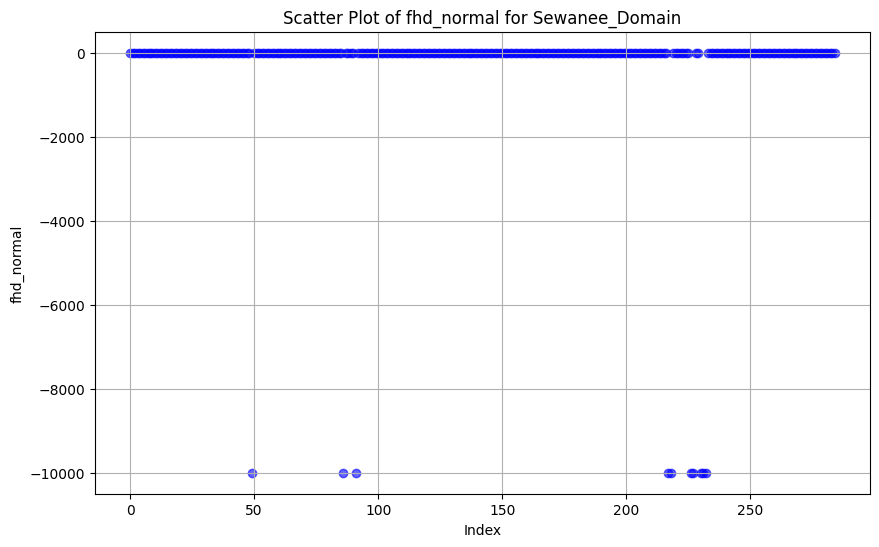

In [85]:
### identfy -9999 no data values to be dropped
plt.figure(figsize=(10, 6))
plt.scatter(Sewanee_Domain.index, Sewanee_Domain['fhd_normal'], c='blue', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('fhd_normal')
plt.title('Scatter Plot of fhd_normal for Sewanee_Domain')
plt.grid(True)
plt.show()

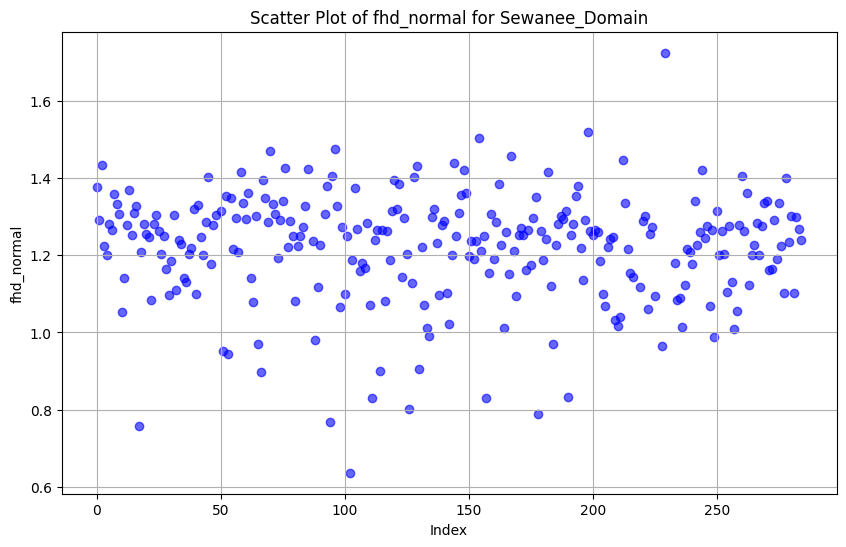

In [86]:
##drop -999 values
Sewanee_Domain_filtered = Sewanee_Domain[Sewanee_Domain['fhd_normal'] != -9999]

plt.figure(figsize=(10, 6))
plt.scatter(Sewanee_Domain_filtered.index, Sewanee_Domain_filtered['fhd_normal'], c='blue', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('fhd_normal')
plt.title('Scatter Plot of fhd_normal for Sewanee_Domain')
plt.grid(True)
plt.show()

/tmp/ipython-input-87-2919523362.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=combined_df, x='site', y='fhd_normal', jitter=True, palette='Set2')


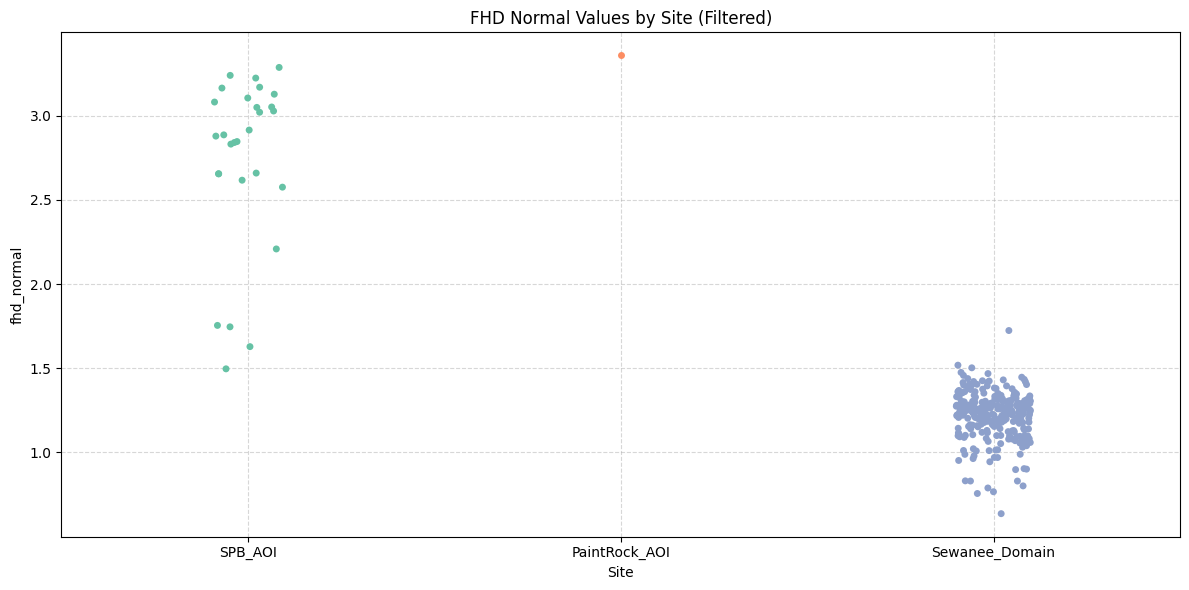

In [87]:
# Combine and filter fhd_normal values from all sites
fhd_data = []

for site, gdf in geo_dfs.items():
    if not gdf.empty and 'fhd_normal' in gdf.columns:
        # Drop rows where fhd_normal is -9999 or NaN
        filtered = gdf[(gdf['fhd_normal'] != -9999) & (gdf['fhd_normal'] != -999999)].copy()
        if not filtered.empty:
            temp_df = filtered[['fhd_normal']].copy()
            temp_df['site'] = site
            fhd_data.append(temp_df)

# Combine into one DataFrame
combined_df = pd.concat(fhd_data, ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=combined_df, x='site', y='fhd_normal', jitter=True, palette='Set2')
plt.title("FHD Normal Values by Site (Filtered)")
plt.ylabel("fhd_normal")
plt.xlabel("Site")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [88]:
import folium
from matplotlib import cm, colors
import pandas as pd

# Initialize map centered on average coordinates of all sites combined
all_lats = []
all_lons = []

for df in geo_dfs.values():
    filtered = df[df['fhd_normal'] != -9999]
    all_lats.extend(filtered['lat'].tolist())
    all_lons.extend(filtered['lon'].tolist())

map_center = [sum(all_lats) / len(all_lats), sum(all_lons) / len(all_lons)]
m = folium.Map(location=map_center, zoom_start=8)

# Define colormap and normalization globally for consistent coloring
all_fhd_values = pd.concat([df[df['fhd_normal'] != -9999]['fhd_normal'] for df in geo_dfs.values()])
norm = colors.Normalize(vmin=all_fhd_values.min(), vmax=all_fhd_values.max())
cmap = cm.get_cmap('viridis')

# Add each AOI as a separate FeatureGroup with colored CircleMarkers
for site_name, df in geo_dfs.items():
    fg = folium.FeatureGroup(name=site_name)
    filtered = df[df['fhd_normal'] != -9999]

    for _, row in filtered.iterrows():
        rh_value = row['fhd_normal']
        if pd.notnull(rh_value):
            color = colors.to_hex(cmap(norm(rh_value)))
            folium.CircleMarker(
                location=(row['lat'], row['lon']),
                radius=3,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.8,
            ).add_to(fg)

    fg.add_to(m)

# Add layer control to toggle AOIs on/off
folium.LayerControl().add_to(m)

# Save and display
m.save('combined_gedi_map.html')
m


/tmp/ipython-input-88-1393329047.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


/tmp/ipython-input-91-968304003.py:32: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim(color_min, color_max)
/tmp/ipython-input-91-968304003.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


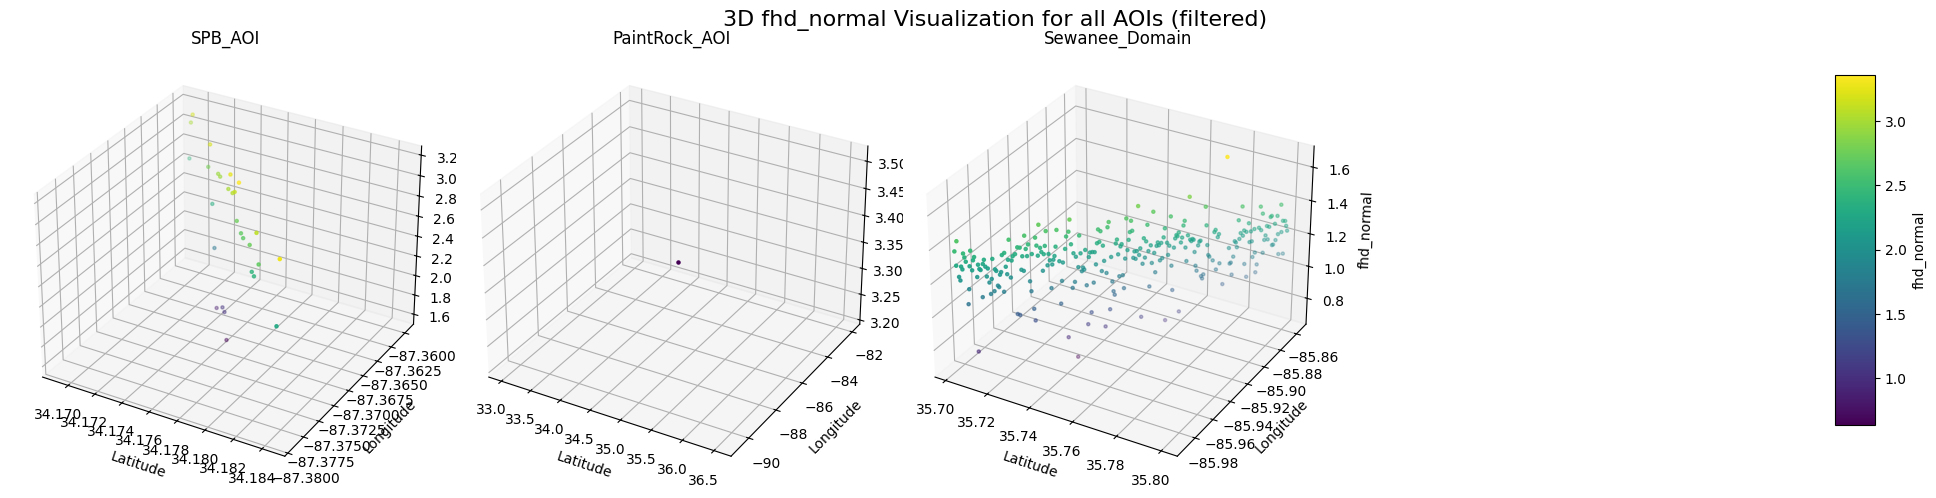

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Clean and filter each GeoDataFrame: drop NaNs and filter out -9999 in 'fhd_normal'
filtered_geo_dfs = {}
for aoi_name, gdf in geo_dfs.items():
    if not gdf.empty:
        df_clean = gdf.dropna(subset=['lat', 'lon', 'fhd_normal'])
        df_clean = df_clean[df_clean['fhd_normal'] != -9999]
        if not df_clean.empty:
            filtered_geo_dfs[aoi_name] = df_clean

fig = plt.figure(figsize=(20, 5))  # wide figure for 4 plots

for i, (aoi_name, df) in enumerate(filtered_geo_dfs.items(), start=1):
    ax = fig.add_subplot(1, 4, i, projection='3d')

    x = df['lat']
    y = df['lon']
    z = df['fhd_normal']
    colors = z
    color_min = colors.min()
    color_max = colors.max()

    scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', s=5, vmin=color_min, vmax=color_max)

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('fhd_normal')
    ax.set_title(aoi_name)
    ax.set_zlim(color_min, color_max)

# Add shared colorbar on right side
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = plt.Normalize(vmin=min(df['fhd_normal'].min() for df in filtered_geo_dfs.values()),
                     vmax=max(df['fhd_normal'].max() for df in filtered_geo_dfs.values()))
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), cax=cbar_ax)
cbar.set_label('fhd_normal')

plt.suptitle('3D fhd_normal Visualization for all AOIs (filtered)', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


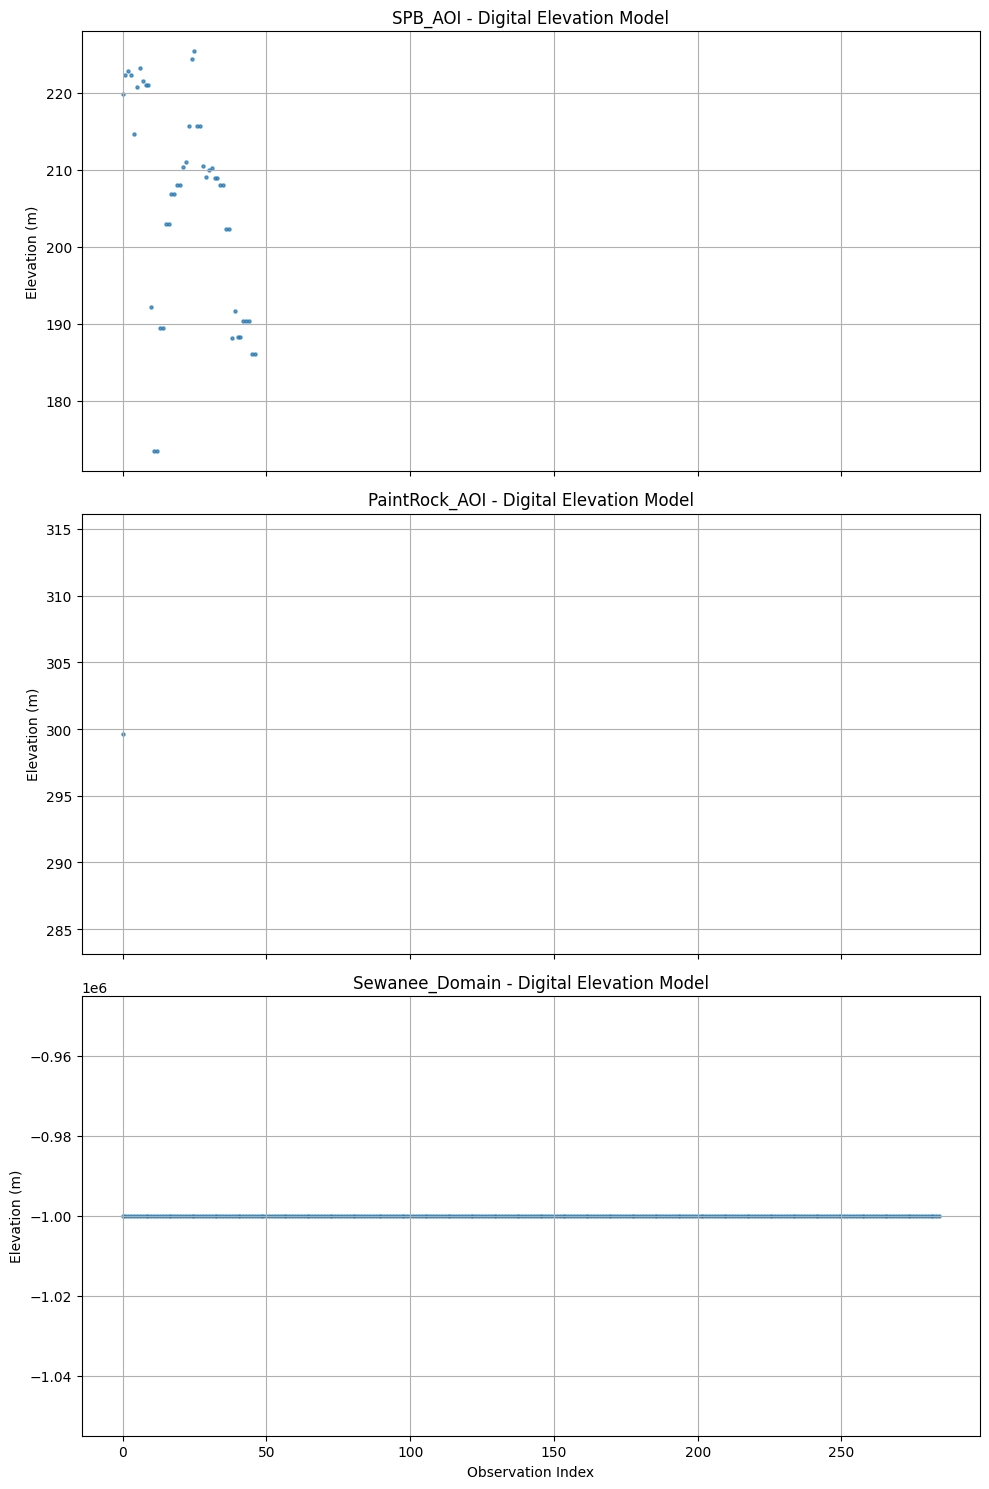

In [101]:
import matplotlib.pyplot as plt

# Number of AOIs
num_aois = len(geo_dfs)
fig, axes = plt.subplots(num_aois, 1, figsize=(10, 5 * num_aois), sharex=True)

if num_aois == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, (aoi_name, gdf) in zip(axes, geo_dfs.items()):
    # Drop rows with missing elevation data
    df = gdf.dropna(subset=['geolocation/digital_elevation_model'])

    # Plot digital elevation model (DEM) vs. index
    ax.scatter(df.index, df['geolocation/digital_elevation_model'], s=5, alpha=0.7)
    ax.set_title(f"{aoi_name} - Digital Elevation Model")
    ax.set_ylabel("Elevation (m)")
    ax.grid(True)

axes[-1].set_xlabel("Observation Index")
plt.tight_layout()
plt.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
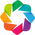

In [98]:
import holoviews as hv
hv.extension('bokeh')

def plot_transect_elevations(filtered_gdf, transect_col='Beam', output_title_prefix='GEDI Beam'):
    """
    Generate elevation transect plots per unique beam in the dataframe.

    Parameters:
    - filtered_gdf: pd.DataFrame or GeoDataFrame with GEDI data.
    - transect_col: str, name of column identifying beam/transect (default: 'Beam')
    - output_title_prefix: str, prefix for plot titles (default: 'GEDI Beam')

    Returns:
    - plots_dict: dict of {beam_name: hv.Overlay} of the combined scatter plots
    """
    plots_dict = {}

    for transect_name, group_df in filtered_gdf.groupby(transect_col):
        group_df = group_df.dropna(subset=[
            'geolocation/digital_elevation_model',
            'geolocation/elev_lowestmode',
            'geolocation/elev_highestreturn'
        ]).copy()

        x_vals = range(len(group_df))

        demVis = hv.Scatter((x_vals, group_df['geolocation/digital_elevation_model']),
                            label='DEM (GEDI)').opts(color='black', size=1.5)

        zVis = hv.Scatter((x_vals, group_df['geolocation/elev_lowestmode']),
                          label='Lowest Mode Elevation').opts(color='saddlebrown', size=1.5)

        rhVis = hv.Scatter((x_vals, group_df['geolocation/elev_highestreturn']),
                           label='Canopy Top Elevation').opts(color='darkgreen', size=1.5, tools=['hover'])

        combined = (demVis * zVis * rhVis).opts(
            title=f'{output_title_prefix} {transect_name} Elevation Profile',
            height=500, width=900,
            show_legend=True, legend_position='top_left',
            xlabel='Observation Index', ylabel='Elevation (m)',
            fontsize={'title': 14, 'xlabel': 16, 'ylabel': 16}
        )

        plots_dict[transect_name] = combined

    return plots_dict


# Now apply this to each GeoDataFrame in geo_dfs, filtering out fhd_normal == -9999 first:

all_plots = {}

for aoi_name, gdf in geo_dfs.items():
    # Filter out invalid fhd_normal values
    filtered_gdf = gdf[gdf['fhd_normal'] != -9999].copy()
    if filtered_gdf.empty:
        print(f"No valid data for {aoi_name} after filtering fhd_normal")
        continue

    plots = plot_transect_elevations(filtered_gdf, transect_col='Beam', output_title_prefix=f'GEDI {aoi_name}')
    all_plots[aoi_name] = plots

# Example: display all transects for one AOI, e.g., 'SPB_AOI'
if 'SPB_AOI' in all_plots:
    hv.Layout(all_plots['SPB_AOI'].values()).cols(1)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
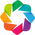

Displaying transect plots for AOI: SPB_AOI


:Layout
   .Overlay.I :Overlay
      .Scatter.DEM_left_parenthesis_GEDI_right_parenthesis :Scatter   [x]   (y)
      .Scatter.Lowest_Mode_Elevation                       :Scatter   [x]   (y)
      .Scatter.Canopy_Top_Elevation                        :Scatter   [x]   (y)

Press Enter to continue to the next AOI...
Displaying transect plots for AOI: PaintRock_AOI


:Layout
   .Overlay.I :Overlay
      .Scatter.DEM_left_parenthesis_GEDI_right_parenthesis :Scatter   [x]   (y)
      .Scatter.Lowest_Mode_Elevation                       :Scatter   [x]   (y)
      .Scatter.Canopy_Top_Elevation                        :Scatter   [x]   (y)

Press Enter to continue to the next AOI...
Displaying transect plots for AOI: Sewanee_Domain


:Layout
   .Overlay.I :Overlay
      .Scatter.DEM_left_parenthesis_GEDI_right_parenthesis :Scatter   [x]   (y)
      .Scatter.Lowest_Mode_Elevation                       :Scatter   [x]   (y)
      .Scatter.Canopy_Top_Elevation                        :Scatter   [x]   (y)

Press Enter to continue to the next AOI...


In [100]:
import holoviews as hv
hv.extension('bokeh')

for aoi_name, plots_dict in all_plots.items():
    print(f"Displaying transect plots for AOI: {aoi_name}")
    layout = hv.Layout(plots_dict.values()).cols(1)
    display(layout)  # In Jupyter/Colab this will render the plot
    # Optionally add a pause or break here to show one AOI at a time
    input("Press Enter to continue to the next AOI...")


xxxxxxxxxxxxx

In [ ]:
# Create pair plot
sns.pairplot(filtered_gdf, hue="fhd_normal", palette="Set2", diag_kind="kde")
plt.suptitle("Pair Plot of GEDI Metrics", y=1.02)
plt.show()


xxxxxxxxxxxxxxxxxxxxxx

##Contact Info:

Email: timothy.j.mayer@nasa.gov

Organization: SERVIR & Earth Hub

Website: XXXXXXXX

Date last modified: 06-24-2025


Funding for this work was provided through the cooperative agreement 80MSFC22N0004 between NASA and UAH. SERVIR is a joint NASA- and USAID-led program